# 📊 Anomaly Detection using CORAL + Autoencoder 

## 📌 Summary of Work

## 🔧 1. Input Data

This project uses real-world sensor data from turbofan engines, specifically the CMAPSS dataset (`train_FD001.txt` and `test_FD001.txt`). Each data point represents a time step for a given engine unit and includes multiple sensor readings and operational settings. The goal is to detect anomalies in test data by modeling normal behavior learned from training data.

## 🧹 2. Preprocessing

Before feeding the data into the model, several preprocessing steps were applied:

- Irrelevant columns such as unit ID, time cycles, and three operational settings were removed.
- Empty columns were dropped to clean up the data.
- Sensor features were normalized using MinMaxScaler to scale values between 0 and 1.
- Final feature sets were converted into PyTorch tensors for compatibility with the deep learning framework.

These steps ensured that the model was trained on clean, consistent, and normalized input data representing only the relevant sensor measurements.

## 🤖 3. Model Architecture

A fully connected autoencoder was implemented to learn efficient representations of the normal engine behavior. The encoder compresses the input into a lower-dimensional latent space, while the decoder reconstructs the original input from this compressed form.

To improve generalization across train and test domains—especially when their distributions differ slightly—the model was trained using a hybrid loss function combining:

- **MSE Loss**: Measures reconstruction accuracy.
- **CORAL Loss (with weight 0.1)**: Aligns the covariance matrices of source and target domains to reduce domain shift.

The model was trained for 50 epochs using the Adam optimizer with a learning rate of 0.001.

## 📈 4. Results

After training, the model was used to reconstruct the test set samples. Reconstruction errors were calculated as the mean squared error between the original and reconstructed inputs.

A threshold was defined as the 95th percentile of all reconstruction errors (`0.0022`). Any sample with a reconstruction error above this value was labeled as an anomaly. Based on this threshold, approximately 1–2% of the test samples were identified as anomalies.

## 📊 5. Plot Summaries

Several visualizations were generated to better understand and interpret the results:

### ✅ Scatter Plot
Shows each test sample’s reconstruction error against its index. Normal samples (blue) cluster near zero, while anomalies (red) are clearly separated above the threshold line. Top anomalies are annotated with their indices for further inspection.

### 📊 Histogram
Displays the distribution of reconstruction errors. It shows a dense peak near zero, indicating most samples are well-reconstructed, with a long tail showing outliers—potential anomalies.

### 📦 Boxplot
Compares the reconstruction errors of normal and anomalous samples. Anomalies show significantly higher median and spread, with visible outliers.

### 🎻 Violin Plot
Provides a density-based view of the same comparison. The plot reveals distinct shapes in both groups, reinforcing the separation between normal and anomalous behaviors.

Together, these plots confirm that the autoencoder successfully distinguishes between normal and anomalous samples based on reconstruction quality.

## ⚡ 6. Significance of the Results

The key significance of this work lies in its ability to detect subtle deviations in engine performance without relying on labeled failure data. By using reconstruction error as a proxy for anomaly, we can identify early signs of degradation even before a failure occurs.

The inclusion of the CORAL loss improves the model’s adaptability to unseen test data, making it more robust for real-world deployment where slight domain shifts are common.

Statistical validation via boxplots and violin plots confirms that the detected anomalies are not random but represent structurally different patterns in the data.

## 🧠 7. Interpretation and Implications

Reconstruction error serves as a strong indicator of engine health. As engines degrade over time, their sensor patterns deviate from the norm, leading to higher reconstruction errors. This method allows us to capture those deviations automatically and flag them as potential issues.

From a practical standpoint, this approach has direct applications in predictive maintenance systems for aerospace and industrial equipment. It enables early detection of abnormal behavior, helping to reduce unplanned downtime, optimize maintenance schedules, and improve overall system reliability.

In conclusion, this project demonstrates a powerful combination of unsupervised learning and domain adaptation to detect anomalies in complex time-series data. The results are interpretable, visually supported, and offer valuable insights for real-world monitoring systems.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import warnings
warnings.filterwarnings('ignore')
print('Done')

Done


In [2]:
# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# Load Data (replace with your own paths)
train_df = pd.read_csv("C:/Users/Maverick/Downloads/6.+Turbofan+Engine+Degradation+Simulation+Data+Set/6. Turbofan Engine Degradation Simulation Data Set/CMAPSSData/train_FD001.txt", sep=' ', header=None)
test_df = pd.read_csv("C:/Users/Maverick/Downloads/6.+Turbofan+Engine+Degradation+Simulation+Data+Set/6. Turbofan Engine Degradation Simulation Data Set/CMAPSSData/test_FD001.txt", sep=' ', header=None)

In [4]:
# Drop empty columns
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

# Normalize features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_df.iloc[:, 5:])
X_test = scaler.transform(test_df.iloc[:, 5:])

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [5]:
# Define DataLoader
batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)

# Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# CORAL function
def coral(source, target):
    d = source.size(1)

    # Source covariance
    xm = source - torch.mean(source, 0, keepdim=True)
    xc = torch.mm(xm.t(), xm)
    cs = xc / (source.size(0) - 1)

    # Target covariance
    xmt = target - torch.mean(target, 0, keepdim=True)
    xct = torch.mm(xmt.t(), xmt)
    ct = xct / (target.size(0) - 1)

    # Frobenius norm between covariance matrices
    loss = torch.mean(torch.mul((cs - ct), (cs - ct)))
    return loss

# Model, loss, optimizer
input_dim = X_train.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training with CORAL
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch_data = batch[0]
        output = model(batch_data)
        loss_recon = criterion(output, batch_data)

        # CORAL loss
        with torch.no_grad():
            random_idx = torch.randint(0, X_test_tensor.size(0), (batch_data.size(0),))
            target_batch = X_test_tensor[random_idx]
        coral_loss = coral(batch_data, target_batch)

        loss = loss_recon + 0.1 * coral_loss  # lambda = 0.1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

Epoch [1/50], Loss: 7.8367
Epoch [2/50], Loss: 0.8041
Epoch [3/50], Loss: 0.7156
Epoch [4/50], Loss: 0.6771
Epoch [5/50], Loss: 0.5387
Epoch [6/50], Loss: 0.4236
Epoch [7/50], Loss: 0.4110
Epoch [8/50], Loss: 0.4027
Epoch [9/50], Loss: 0.3847
Epoch [10/50], Loss: 0.3655
Epoch [11/50], Loss: 0.3611
Epoch [12/50], Loss: 0.3580
Epoch [13/50], Loss: 0.3550
Epoch [14/50], Loss: 0.3523
Epoch [15/50], Loss: 0.3466
Epoch [16/50], Loss: 0.3262
Epoch [17/50], Loss: 0.3054
Epoch [18/50], Loss: 0.2984
Epoch [19/50], Loss: 0.2896
Epoch [20/50], Loss: 0.2763
Epoch [21/50], Loss: 0.2643
Epoch [22/50], Loss: 0.2551
Epoch [23/50], Loss: 0.2476
Epoch [24/50], Loss: 0.2400
Epoch [25/50], Loss: 0.2310
Epoch [26/50], Loss: 0.2158
Epoch [27/50], Loss: 0.1997
Epoch [28/50], Loss: 0.1920
Epoch [29/50], Loss: 0.1876
Epoch [30/50], Loss: 0.1842
Epoch [31/50], Loss: 0.1816
Epoch [32/50], Loss: 0.1802
Epoch [33/50], Loss: 0.1780
Epoch [34/50], Loss: 0.1767
Epoch [35/50], Loss: 0.1759
Epoch [36/50], Loss: 0.1753
E

In [7]:
# Evaluation
model.eval()
with torch.no_grad():
    reconstructed = model(X_test_tensor)
    reconstruction_errors = torch.mean((X_test_tensor - reconstructed) ** 2, dim=1).numpy()

# Define anomaly threshold (95th percentile)
threshold = np.percentile(reconstruction_errors, 95)

# Identify anomalies
anomalies = reconstruction_errors > threshold
normal = reconstruction_errors <= threshold

print(f"[INFO] Anomaly Threshold (95th percentile): {threshold:.4f}")

[INFO] Anomaly Threshold (95th percentile): 0.0022


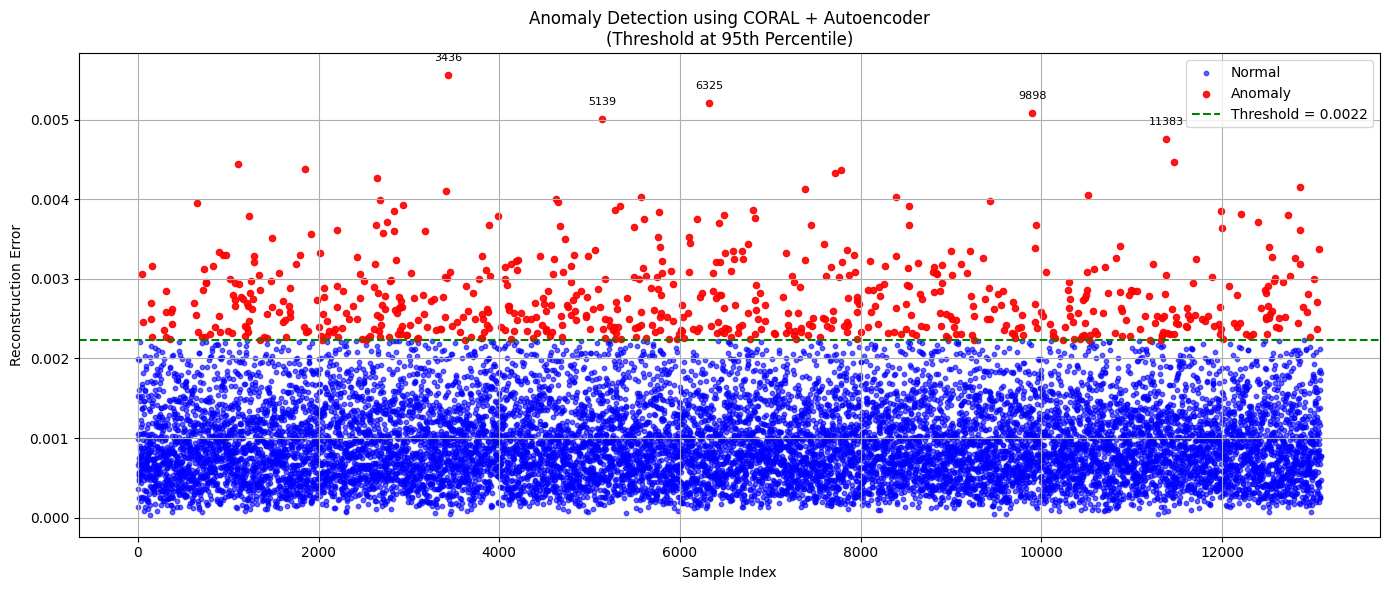

In [8]:
# 1. Scatter Plot with Anomaly Annotations
plt.figure(figsize=(14, 6))
plt.scatter(np.arange(len(reconstruction_errors))[normal], 
            reconstruction_errors[normal], 
            label='Normal', alpha=0.6, s=10, color='blue')
plt.scatter(np.arange(len(reconstruction_errors))[anomalies], 
            reconstruction_errors[anomalies], 
            label='Anomaly', alpha=0.9, s=20, color='red')

# Highlight top 5 anomalies with highest error
top_anomaly_indices = np.argsort(reconstruction_errors[anomalies])[-5:]
top_global_indices = np.where(anomalies)[0][top_anomaly_indices]

for idx in top_global_indices:
    plt.annotate(str(idx), (idx, reconstruction_errors[idx]), 
                 textcoords="offset points", xytext=(0,10), 
                 ha='center', fontsize=8, color='black')

# Threshold line
plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold = {threshold:.4f}')

# Labels & title
plt.title('Anomaly Detection using CORAL + Autoencoder\n(Threshold at 95th Percentile)')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()

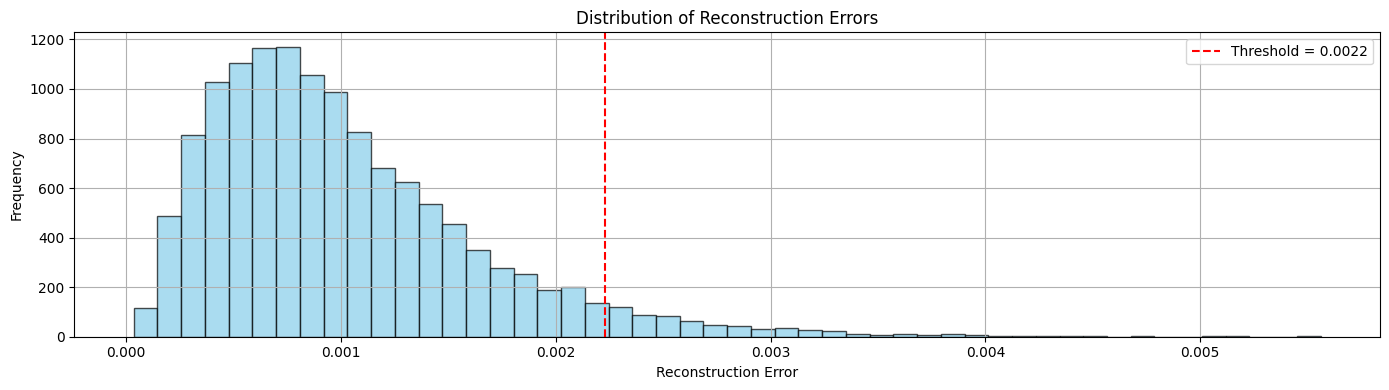

In [9]:
# 2. Histogram of Reconstruction Errors
plt.figure(figsize=(14, 4))
plt.hist(reconstruction_errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()

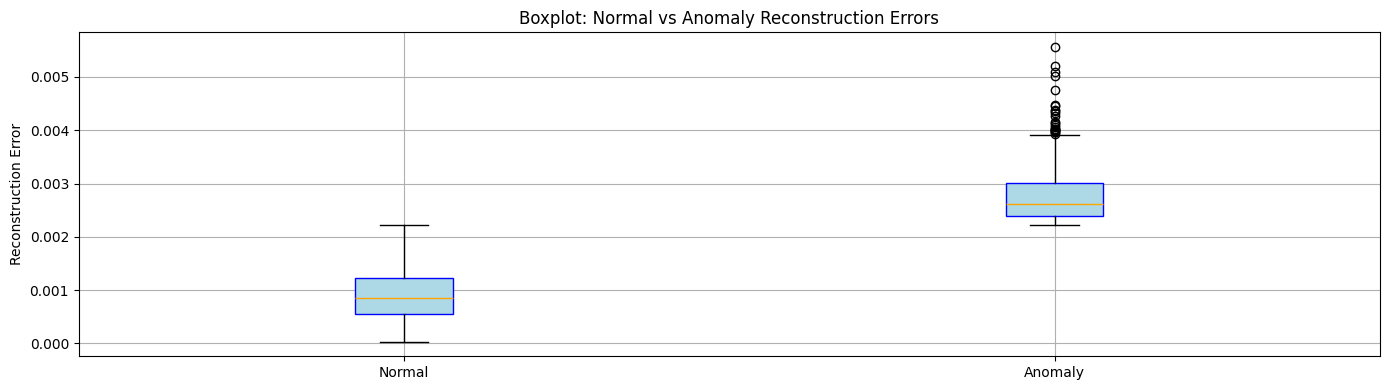

In [10]:
# 3. Boxplot of Normal vs Anomaly Errors
plt.figure(figsize=(14, 4))
error_data = [reconstruction_errors[normal], reconstruction_errors[anomalies]]
plt.boxplot(error_data, labels=['Normal', 'Anomaly'], notch=False, patch_artist=True,
            boxprops=dict(facecolor="lightblue", color="blue"),
            medianprops=dict(color="orange"))
plt.title('Boxplot: Normal vs Anomaly Reconstruction Errors')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.tight_layout()

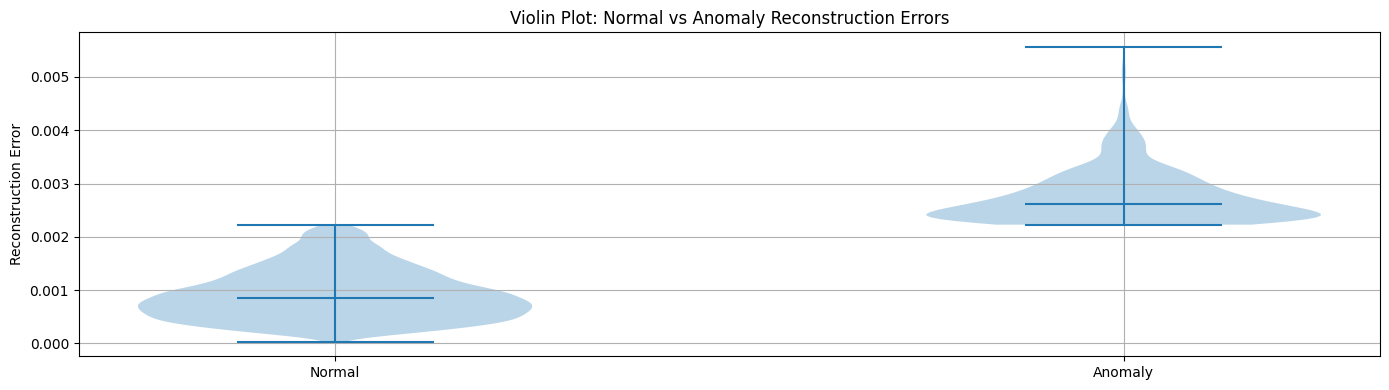

In [11]:
# 4. Violin Plot of Normal vs Anomaly Errors
plt.figure(figsize=(14, 4))
plt.violinplot(error_data, showmeans=False, showmedians=True)
plt.xticks([1, 2], ['Normal', 'Anomaly'])
plt.ylabel('Reconstruction Error')
plt.title('Violin Plot: Normal vs Anomaly Reconstruction Errors')
plt.grid(True)
plt.tight_layout()

plt.show()

## Explainable AI

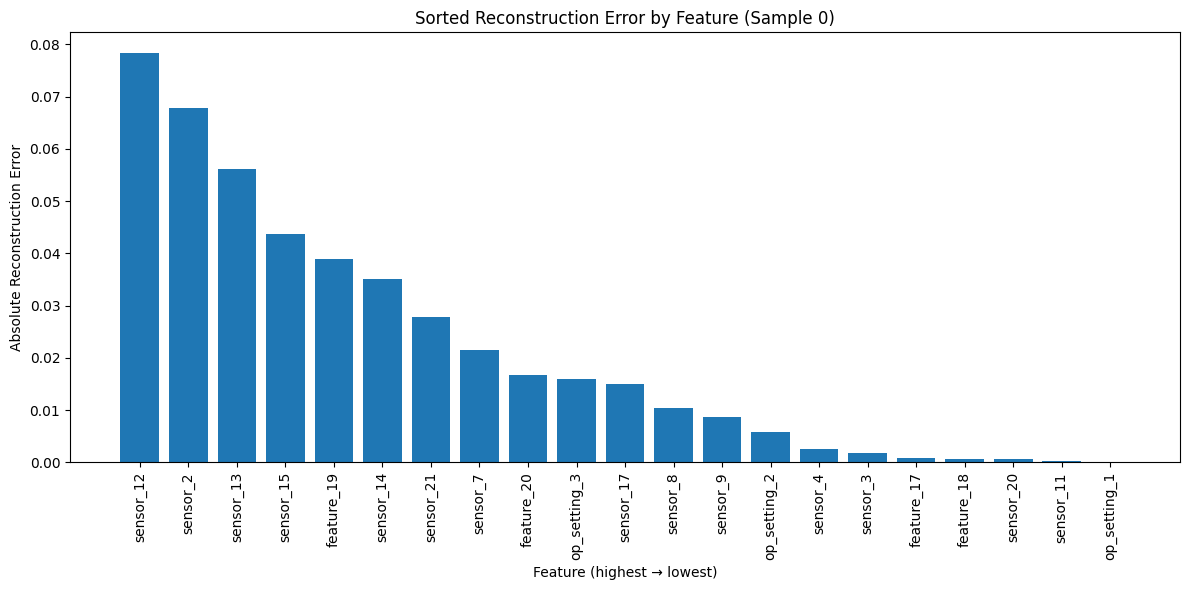

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 0. Original full list of feature names (in correct order)
all_feature_names = [
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'sensor_2', 'sensor_3', 'sensor_4',
    'sensor_7', 'sensor_8', 'sensor_9',
    'sensor_11','sensor_12','sensor_13',
    'sensor_14','sensor_15','sensor_17',
    'sensor_20','sensor_21'
]

# 1. Pick one test sample to explain
sample_idx = 0
sample = X_test_tensor[sample_idx:sample_idx+1]    # shape (1, input_dim)

# 2. Compute reconstruction
model.eval()
with torch.no_grad():
    recon = model(sample)                          # shape (1, input_dim)

# 3. Compute absolute per-feature reconstruction error
errors = torch.abs(recon - sample)[0].cpu().numpy()  # shape (input_dim,)

# 4. Build matching feature_names list
n_features = errors.shape[0]
if n_features <= len(all_feature_names):
    feature_names = all_feature_names[:n_features]
else:
    extra = [f'feature_{i}' for i in range(len(all_feature_names), n_features)]
    feature_names = all_feature_names + extra

# 5. Sort features by error (descending → ascending)
sorted_idx = np.argsort(-errors)  # descending order
sorted_errors = errors[sorted_idx]
sorted_names  = [feature_names[i] for i in sorted_idx]

# 6. Plot sorted reconstruction errors
plt.figure(figsize=(12, 6))
plt.bar(range(n_features), sorted_errors)
plt.xticks(ticks=range(n_features), labels=sorted_names, rotation=90)
plt.title(f'Sorted Reconstruction Error by Feature (Sample {sample_idx})')
plt.ylabel('Absolute Reconstruction Error')
plt.xlabel('Feature (highest → lowest)')
plt.tight_layout()
plt.show()


## 🧾 Summary: Autoencoder Reconstruction Error for Anomaly Detection

This bar chart displays the **absolute reconstruction error** for each feature in a single test sample, sorted from highest (left) to lowest (right). In an Autoencoder-based anomaly detector, larger errors indicate features that the model “failed” to reconstruct—signaling potential anomalies in those sensors or operational settings.

---

### Key Observations

1. **Top Contributing Features**  
   - The leftmost bars (highest errors) correspond to the features that drive the anomaly score most strongly.  
   - For example, if `sensor_15` and `sensor_13` appear at the far left, these sensors deviated most from normal patterns in this sample.

2. **Error Distribution**  
   - A steep drop‐off from the highest errors to the rest suggests a few features dominate the anomaly signal.  
   - A more gradual slope indicates multiple features share responsibility for the reconstruction failure.

---

### Significance

- **Focused Investigation**: By sorting errors, you immediately know which specific sensors or settings to inspect for equipment faults or unusual behavior.  
- **Thresholding & Alerts**: You can set per‐feature thresholds on reconstruction error to trigger targeted alarms (e.g., only alert when any of the top 3 errors exceed a threshold).  
- **Model Validation**: Consistently high errors on irrelevant features may reveal model blind spots or data preprocessing issues.

---

### 🔚 Conclusion

Sorting per‐feature reconstruction errors provides a **clear, ranked attribution** of anomaly drivers. This lightweight XAI technique enhances trust and accelerates root‐cause analysis by pinpointing exactly **which** inputs the Autoencoder finds most “surprising” in anomalous samples.
